# Learning Breast Cancer Bayesian network 

## Load dataset 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyAgrum as gum
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.explain as explain
import pyAgrum.lib.bn_vs_bn as bnvsbn
import pyAgrum.lib.bn2roc as bn2roc
import pyAgrum.lib.bn2scores as bn2scores

pd.set_option('display.max_rows', 15)

# load dataset
df = pd.read_csv("datasets/bc.csv")
df

,BreastDensity,Location,Age,BC,Mass,AD,Metastasis,MC,Size,Shape,FibrTissueDev,LymphNodes,SkinRetract,NippleDischarge,Spiculation,Margin
0,high,LolwOutQuad,35-49,No,No,No,no,No,<1cm,Other,No,no,No,No,No,Well-defined
1,medium,UpOutQuad,50-74,Invasive,Benign,No,yes,Yes,<1cm,Oval,No,yes,No,Yes,No,Well-defined
2,low,UpInQuad,50-74,Invasive,Benign,No,yes,No,1-3cm,Other,Yes,yes,Yes,No,Yes,Well-defined
3,medium,LowInQuad,>75,Invasive,Malign,No,yes,Yes,<1cm,Round,No,no,No,No,No,Ill-defined
4,high,LowInQuad,<35,No,Benign,No,no,No,>3cm,Oval,No,no,No,No,Yes,Ill-defined
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,medium,LowInQuad,35-49,Invasive,Malign,No,yes,No,1-3cm,Irregular,No,yes,No,No,No,Ill-defined
19996,medium,UpOutQuad,50-74,Invasive,Malign,Yes,yes,No,1-3cm,Irregular,No,yes,No,No,No,Ill-defined
19997,low,UpInQuad,35-49,No,No,No,no,No,<1cm,Other,Yes,no,No,No,No,Well-defined
19998,medium,UpOutQuad,50-74,No,No,No,no,No,<1cm,Other,No,no,No,No,No,Well-defined


In [2]:
df['BC'].value_counts() / df.shape[0]

No          0.62195
Invasive    0.23615
Insitu      0.14190
Name: BC, dtype: float64

## Load target BN and create template without structure

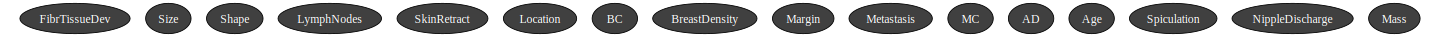

(pyAgrum.BayesNet<double>@0x2501b6cdf70) BN{nodes: 16, arcs: 18, domainSize: 10^6.42393, dim: 106, mem: 1Ko 360o}

In [2]:
bn_target = gum.loadBN("bc.net")

temp = gum.BayesNet()

for name in bn_target.names():
    temp.add(bn_target.variableFromName(name))

gnb.showBN(temp, size=20)

bn_target

## Learn BN

In [3]:
get_arcs = lambda bn: {(bn.variable(f).name(), bn.variable(t).name()) for (f, t) in bn.arcs()}

def evaluate_structure(learner, bn_cmp_to):
       N = bn_target.size()
       bn = learner.learnBN()

       cmp = bnvsbn.GraphicalBNComparator(bn_cmp_to, bn)
       skeleton_scores = cmp.skeletonScores()

       shd = cmp.hamming()["structural hamming"]
       dist2bn = skeleton_scores["dist2opt"]
       cm = skeleton_scores["count"]
       present_edges = len(get_arcs(bn).intersection(get_arcs(bn_cmp_to)))
       absent_edges  = (N * (N-1))/2 - present_edges
       if absent_edges == 0 or present_edges == 0: return (shd, dist2bn, None)
       bsf = (cm["tp"]/present_edges + 
              cm["tn"]/absent_edges + 
              cm["fp"]/absent_edges + 
              cm["fn"]/present_edges)/2
       return (bn, shd, dist2bn, bsf, cm)

learner = gum.BNLearner(df, temp)
learner.useGreedyHillClimbing()
(bn, shd, ed, bsf, cm) = evaluate_structure(learner, bn_target)
bn.setProperty("name", "Learnt BN")

print(learner)

print(f"SHD: {shd}")
print(f"ED:  {ed}")
print(f"BSF: {bsf}")
print(f"\nConfusion matrix")
print(f"----------------------")
print(f"| TP: {cm['tp']}  |  FP: {cm['fp']}   |")
print(f"----------------------")
print(f"| FN: {cm['fn']}   |  TN: {cm['tn']} |")
print(f"----------------------")
bn

Filename       : C:\Users\janba\AppData\Local\Temp\tmppktgb93v.csv
Size           : (20000,16)
Variables      : FibrTissueDev[2], Shape[4], LymphNodes[2], Size[3], SkinRetract[2], Location[4], BC[3], BreastDensity[3], Margin[2], Metastasis[2], MC[2], AD[2], Age[4], Spiculation[2], NippleDischarge[2], Mass[3]
Induced types  : False
Missing values : False
Algorithm      : Greedy Hill Climbing
Score          : BDeu
Correction     : MDL  (Not used for score-based algorithms)
Prior          : -

SHD: 8
ED:  0.0
BSF: 1.0857142857142856

Confusion matrix
----------------------
| TP: 18  |  FP: 0   |
----------------------
| FN: 0   |  TN: 102 |
----------------------


(pyAgrum.BayesNet<double>@0x2501b711660) BN{nodes: 16, arcs: 18, domainSize: 10^6.42393, dim: 88, mem: 1Ko 120o}

In [4]:
gnb.flow.add(bnvsbn.graphDiff(bn_target, bn))
gnb.flow.add(bnvsbn.graphDiffLegend(), "Legend")

f = open("./html_images/breast_cancer_bn_diff.html", "w")
f.write(gnb.flow.sHtml)
f.close()

gnb.flow.display()

## Classification performance

In [5]:
from pyAgrum import skbn

Classifier = skbn.BNClassifier()

Classifier.fromTrainedModel(bn, "BC", "No")
X, y = Classifier.XYfromCSV("datasets/bc.csv", with_labels=True, target="BC")
predictions = Classifier.predict_proba(X)

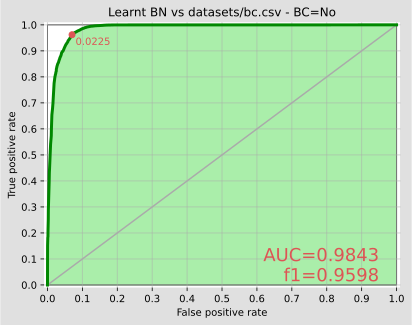

(0.984333062605134, 0.02250498125, 0.9876364272250416, 0.00803564265)

In [30]:
bn2roc.showROC(bn, "datasets/bc.csv",'BC', "No", show_progress=False)

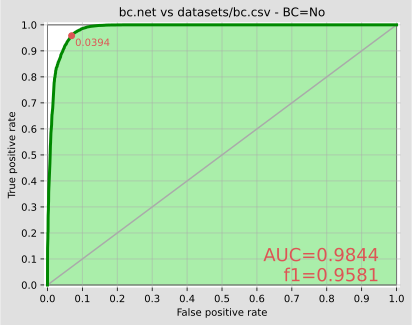

(0.9844364689607249, 0.03940212585, 0.9877535906867647, 0.0138384002)

In [31]:
bn2roc.showROC(bn_target, "datasets/bc.csv",'BC', "No", show_progress=False)

datasets/bc.csv: 100%|██████████|


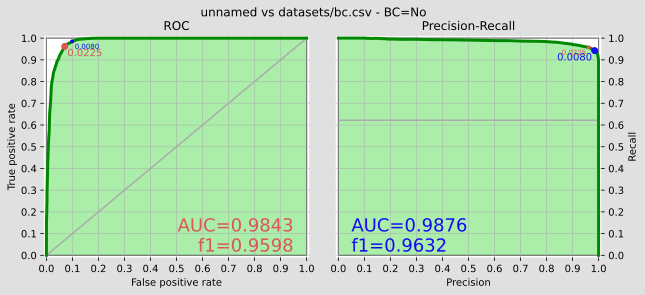

datasets/bc.csv: 100%|██████████|


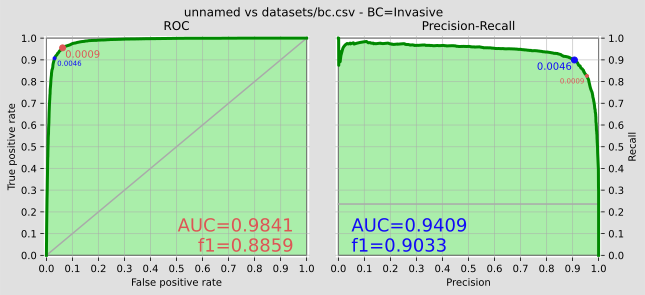

datasets/bc.csv: 100%|██████████|


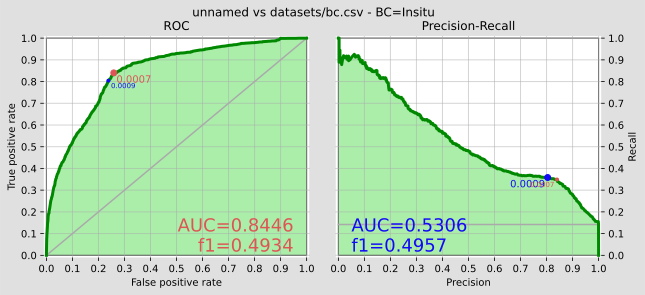

(0.844572528552889, 0.0007426601000000001, 0.5306222847339311, 0.00086981405)

In [15]:
bn2roc.showROC_PR(bn, "datasets/bc.csv",'BC',"No", show_progress=True)
bn2roc.showROC_PR(bn, "datasets/bc.csv",'BC',"Invasive", show_progress=True)
bn2roc.showROC_PR(bn, "datasets/bc.csv",'BC',"Insitu", show_progress=True)

datasets/bc.csv: 100%|██████████|


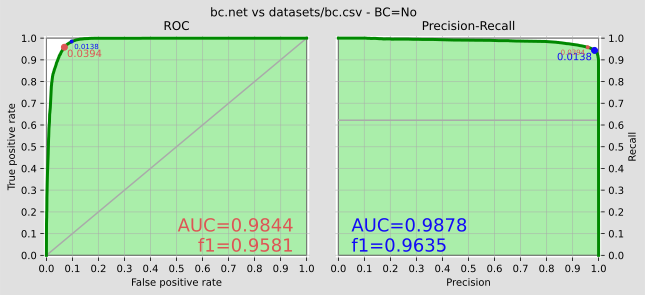

datasets/bc.csv: 100%|██████████|


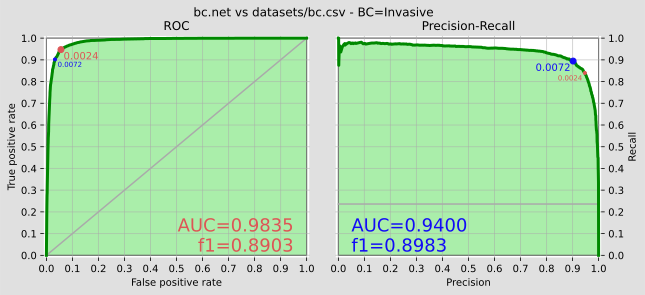

datasets/bc.csv: 100%|██████████|


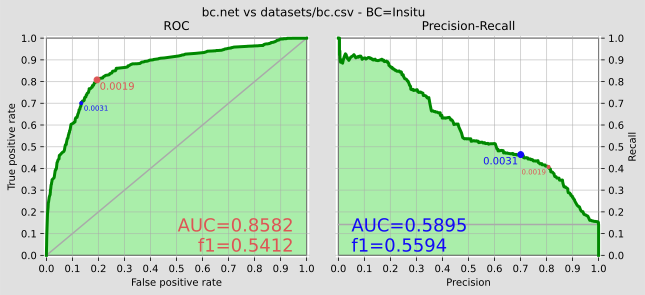

(0.8581875107328178, 0.0019173229, 0.5894956698774498, 0.0031178686)

In [16]:
bn2roc.showROC_PR(bn_target, "datasets/bc.csv",'BC',"No", show_progress=True)
bn2roc.showROC_PR(bn_target, "datasets/bc.csv",'BC',"Invasive", show_progress=True)
bn2roc.showROC_PR(bn_target, "datasets/bc.csv",'BC',"Insitu", show_progress=True)

In [33]:
_, learnt_scores = bn2scores.computeScores(bn, "datasets/bc.csv", visible=False)
_, target_scores = bn2scores.computeScores(bn_target, "datasets/bc.csv", visible=False)

In [34]:
learnt_scores, target_scores

({'likelihood': -261159.65452659343,
  'aic': -261249.65452659343,
  'aicc': -522500.1317140276,
  'bic': -262445.54864075285,
  'mdl': -264311.1210618049},
 {'likelihood': -261122.43795487448,
  'aic': -261228.43795487448,
  'aicc': -522458.01609572535,
  'bic': -262636.9354671067,
  'mdl': -264771.61677770637})

In [36]:
print(f"log-likelihood error: {abs(learnt_scores['likelihood'] - target_scores['likelihood'])}")
print(f"BIC error:            {abs(learnt_scores['bic'] - target_scores['bic'])}")

log-likelihood error: 37.216571718949126
BIC error:            191.38682635384612


## Structural constraints

In [41]:
learner = gum.BNLearner(df, temp)
learner.useGreedyHillClimbing()
learner.addMandatoryArc("Age", "BC")
bn_man_age = evaluate_structure(learner, bn_target)
bn_man_age[0].setProperty("name", "Learnt BN (mandatory 'Age')")

learner = gum.BNLearner(df, temp)
learner.useGreedyHillClimbing()
learner.addMandatoryArc("Location", "BC")
bn_man_loc = evaluate_structure(learner, bn_target)
bn_man_loc[0].setProperty("name", "Learnt BN (mandatory 'Location')")

In [42]:
gnb.flow.add(bnvsbn.graphDiff(bn_target, bn_man_age[0]))
gnb.flow.add(bnvsbn.graphDiff(bn_target, bn_man_loc[0]))
gnb.flow.add(bnvsbn.graphDiffLegend(), "Legend")
gnb.flow.display()

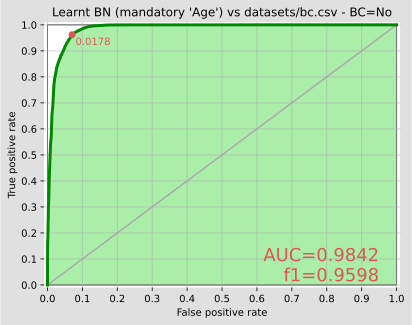

(0.9842411871932114, 0.01779695335, 0.9875601505779416, 0.00487597945)

In [50]:
bn2roc.showROC(bn_man_age[0], "datasets/bc.csv",'BC', "No", show_progress=False)

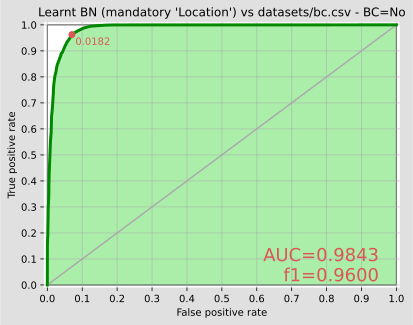

(0.9843429933579101,
 0.018224362350000002,
 0.98764647320664,
 0.0060647168500000005)

In [49]:
bn2roc.showROC(bn_man_loc[0], "datasets/bc.csv",'BC', "No", show_progress=False)